In [1]:
# enable plotting in the notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# make plots more readable
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize']=[10,7]

# Prerequisites

This demo uses MNIST, which we use torchvision to download. We also use tqdm to give a simple progress bar. If you don't have torchvision or tqdm, uncomment the next cell to install them into your current environment.

In [3]:
#!pip install torchvision tqdm

# Loading MNIST

The following cell will download the MNIST dataset into the current directory, and load the training split as double precision floats. The integer labels are held in a 60,000-by-10 tensor `Y`.

In [4]:
# load mnist
import torch
from torchvision import datasets
d = datasets.MNIST('./dataMNIST', train=True, download=True)
#d = datasets.FashionMNIST('./dataFashion', train=True, download=True)
#d = datasets.CIFAR10('./dataCIFAR10', train=True, download=True)
#X = torch.Tensor(d.train_data)
#X = X[:,:,:,0] # for RGB datasets like CIFAR
#Y = torch.Tensor(d.train_labels)
ids = range(0,d.train_data.shape[0], 1)
X = d.train_data[ids,...].type(torch.float64)
X = X.view(X.shape[0],1,X.shape[1],X.shape[2])
Y = d.train_labels[ids]

# Simple affine atlas building

To do atlas building with lagomorph, we'll restrict our focus to one class at a time.

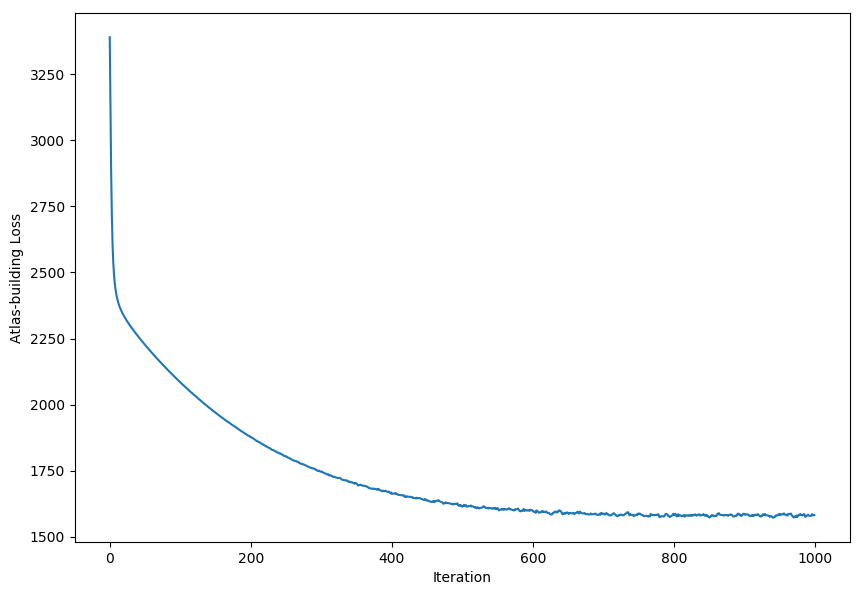

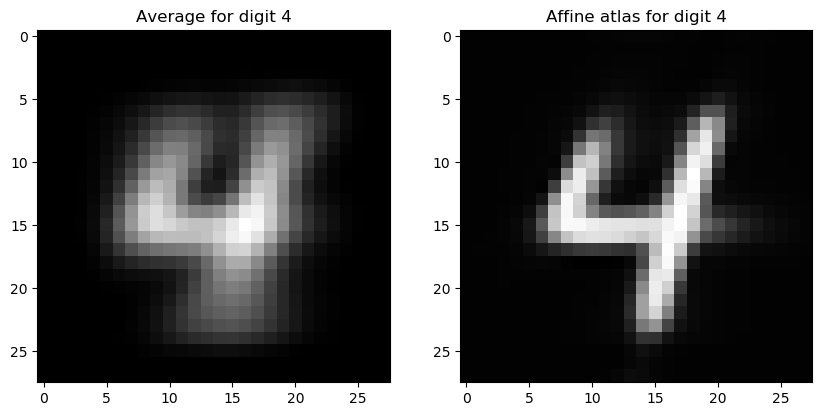

In [5]:
import lagomorph as lm
from tqdm import tqdm_notebook as tqdm
def affine_atlas(J, 
        num_iters=1000,
        step_sizeA = 1e-1,
        step_sizeT = 1e-0,
        step_sizeI = 1.,
        regweightA = 1e-2,
        regweightT = 1e-2,
        momentum = .5):    
    # initialize base image to mean
    I = J.mean(dim=0).view(1,1,28,28)
    losses = []
    regterms = []
    # initialize affine matrices (A) and translations (T)
    A = torch.zeros((J.shape[0],2,2), dtype=J.dtype)
    A[:,0,0] = 1
    A[:,1,1] = 1
    A = A.to(J.device)
    T = torch.zeros((J.shape[0],2), dtype=J.dtype).to(J.device)
    from torch.nn.functional import mse_loss
    A.requires_grad = True
    T.requires_grad = True
    I.requires_grad = True
    pA = 0
    pT = 0
    meanA = torch.zeros((1,2,2), dtype=J.dtype)
    meanA[0,0,0] = 1
    meanA[0,1,1] = 1
    meanA = meanA.to(J.device)
    for n in tqdm(range(num_iters)):
        if A.grad is not None:
            A.grad.detach_()
            A.grad.zero_()
            T.grad.detach_()
            T.grad.zero_()
            I.grad.detach_()
            I.grad.zero_()
        Idef = lm.affine_interp(I, A, T)
        regterm = regweightT*((T)**2).mean() + regweightA*((A-meanA)**2).mean()
        regtermi = regterm.item()
        regterms.append(regtermi)
        loss = mse_loss(Idef, J) + regterm
        losses.append(loss.item() + regtermi)
        loss.backward()
        pA = momentum*pA + A.grad
        A.data = A.data - step_sizeA*pA
        pT = momentum*pT + T.grad
        T.data = T.data - step_sizeT*pT
        pA.detach_()
        pA.detach_()
        with torch.no_grad():
            I.data = I.data - step_sizeI*I.grad
    return I, losses, regterms
c = 4 # which digit to build an atlas for
J = X[Y==c,...].cuda()
I, losses, regterms = affine_atlas(J)
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Atlas-building Loss')
plt.figure()
plt.subplot(1,2,1)
plt.imshow(J.mean(dim=0).view(1,1,28,28).cpu().numpy().squeeze(), cmap='gray')
plt.title(f'Average for digit {c}')
plt.subplot(1,2,2)
plt.imshow(I.cpu().detach().numpy().squeeze(), cmap='gray')
plt.title(f'Affine atlas for digit {c}');

# Remarks

Notice that in the above code, we only use a single lagomorph function, `affine_interp`. In particular, we do not need to explicitly handle differentiation as that is managed by the `pytorch.autograd` interface used by lagomorph.

Note also that we do not solve for the image in closed form in this example. Commonly we would "splat" the images back to their aligned configurations then average, weighting by the jacobian of that transform. While that is the closed-form optimum in the continuum, that does not hold for discretized images, so instead we use gradient descent. Note that a Jacobi method is available to accelerate the base image estimation but that will be the topic of another notebook.